# Projet : Consommation et production électrique en France: Exploration du dataset Régional

_________________________________________
### 0.Organisation
_________________________________________

#### 0.1. Extract and transform data

In [1]:
#Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### 0.2. Useful functions

In [2]:
# Creating function to extract and concatenate csv files

def create_datetime_indexes( df ):
    datetime_index = pd.DatetimeIndex(df['Date'] + ' ' + df['Heures'])
    df.index = datetime_index
    df = df.drop(columns=['Date', 'Heures'])
    return df

def extract_clean( files, cols ) :

    # Ceci est un générateur. Les données ne sont pas calculées immédiatement.
    # Mais il me garatit que l'information sera disponible au moment où j'en ai besoin. 
    # https://book.pythontips.com/en/latest/generators.html
    # En compréhension de générateur : 
    # https://python-reference.readthedocs.io/en/latest/docs/comprehensions/gen_expression.html

    gen = ( pd.read_csv(
            filepath_or_buffer=f, 
            sep='\t', 
            encoding='ISO-8859-1', 
            na_values=['ND', '-', 'NA'],
            index_col=False) 
       for f in files 
    )
    
    # Ici j'ai mis un exemple d'utilisation de 'pipe' pour brancher une fonction au milieu du chaînage.
    # Pipe : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pipe.html
    return (
        pd.concat( gen )
        .dropna(
            subset=['Consommation', 'Date', 'Heures'],
            how='any')
        .loc[:, cols]
        .pipe(create_datetime_indexes)
    )


#### 0.3. Preparing to load


In [3]:
# Prepare the list of files to load
data_folder = '../data_rte/'
files = os.listdir(data_folder)
regional_files = [ data_folder + f for f in files if 'eCO2mix_RTE_Annuel' not in f ]

cols = [ 'Périmètre', 'Date', 'Heures', 'Consommation', 'Thermique',
       'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 'Pompage',
       'Bioénergies', 'Ech. physiques'
]

df_regional = extract_clean( regional_files, cols )

df_regional.to_pickle('./data_rte_regional.pkl')

#df_regional.info()

/tmp/ipykernel_5498/2263363627.py:17: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  gen = ( pd.read_csv(


#### 0.4. Preliminary Analysis

In [4]:
# Converting to pickle
df_regional = pd.read_pickle('./data_rte_regional.pkl')
#df_regional.info()

In [5]:
# Set of Regions
df_regional['Périmètre'].unique()

array(['Ile-de-France', 'Bretagne', 'Hauts-de-France', 'Normandie',
       'Bourgogne-Franche-Comté', 'PACA', 'Centre-Val de Loire',
       'Occitanie', 'Pays-de-la-Loire', 'Auvergne-Rhône-Alpes',
       'Nouvelle-Aquitaine', 'Grand-Est'], dtype=object)

In [6]:
# Do I have the number of values for each region ?
df_regional['Périmètre'].value_counts()

Périmètre
Ile-de-France              105167
Bretagne                   105167
Hauts-de-France            105167
Normandie                  105167
Bourgogne-Franche-Comté    105167
PACA                       105167
Centre-Val de Loire        105167
Occitanie                  105167
Pays-de-la-Loire           105167
Auvergne-Rhône-Alpes       105167
Nouvelle-Aquitaine         105167
Grand-Est                  105167
Name: count, dtype: int64

____________________________________________________
### 1.Analyse générale
____________________________________________________

##### 1.0. Organizing and Cleaning Regional Consumption Dataframe

In [7]:
# Defining a new variable (regional_consomption)
regional_consomption = df_regional

In [8]:
#Cleaning Regional Consumption dataset
regional_consomption = (regional_consomption.drop(columns=['Thermique', 'Nucléaire', 'Eolien', 
                                                            'Solaire', 'Hydraulique', 
                                                            'Pompage', 'Bioénergies', 'Ech. physiques'])
                                            .reset_index()
                                            .rename(columns={'Périmètre': 'Regions',
                                                            'Consommation': 'Consomption(Gwh)',
                                                            'index': 'Datetime'})
                                            
)

In [9]:
regional_consomption['Datetime'] = pd.to_datetime(regional_consomption['Datetime'])
regional_consomption = (regional_consomption.groupby(['Regions', 
                                         pd.Grouper(key='Datetime', freq='Y')])['Consomption(Gwh)']
                                         .sum()
                                         .loc[:, '2018']
                                         .astype(int)
                        )


In [10]:
regional_consomption = pd.DataFrame(regional_consomption)

In [11]:
regional_consomption = (regional_consomption.reset_index())

regional_consomption

,Regions,Consomption(Gwh)
0,Auvergne-Rhône-Alpes,134068058
1,Bourgogne-Franche-Comté,42829648
2,Bretagne,45053105
3,Centre-Val de Loire,37557332
4,Grand-Est,91868917
5,Hauts-de-France,101815048
6,Ile-de-France,141593960
7,Normandie,56079329
8,Nouvelle-Aquitaine,87595610
9,Occitanie,76903481


#### 1.1. Tracer sur un même graphique la consommation des différentes régions en fonction du temps

<AxesSubplot:>

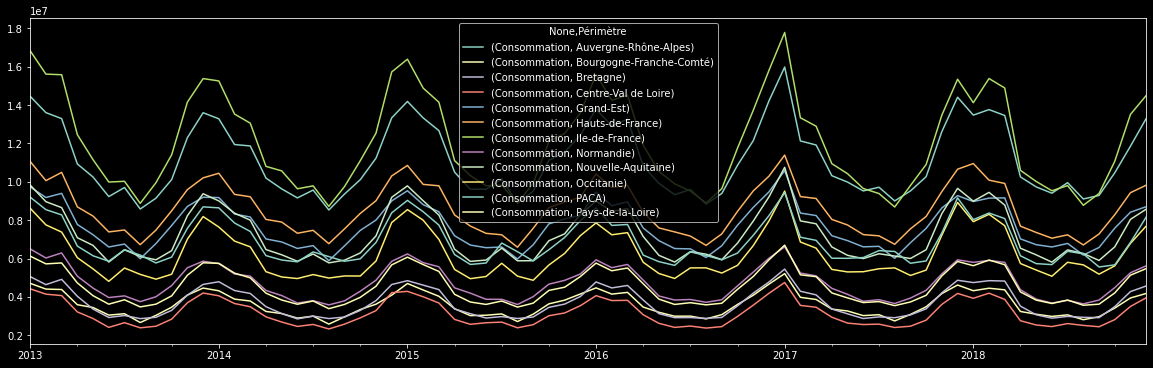

In [12]:
# Plotting Energy Consumption per Region

regional_consomption_plot = (df_regional.drop(columns=['Thermique', 'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 
                                    'Pompage', 'Bioénergies', 'Ech. physiques'])
                                            .groupby(['Périmètre', pd.Grouper(freq="M")])
                                            .sum()
                                            .unstack(level=0)
                                            
                                             )


regional_consomption_plot.plot(figsize=(20, 6))
                                

#### 1.2. Peut-on observer des différences comportementales significatives entre les régions ? (par ex entre une région du nord et une région du sud)

In [94]:
#

#### 1.3. Quelles régions sont les plus consommatrices ?

In [13]:
# Sort values 
regional_consomption.sort_values(by='Consomption(Gwh)', ascending=False)

,Regions,Consomption(Gwh)
6,Ile-de-France,141593960
0,Auvergne-Rhône-Alpes,134068058
5,Hauts-de-France,101815048
4,Grand-Est,91868917
8,Nouvelle-Aquitaine,87595610
10,PACA,80884421
9,Occitanie,76903481
7,Normandie,56079329
11,Pays-de-la-Loire,54793090
2,Bretagne,45053105


#### 1.4. Quelles régions sont les plus consommatrices par rapport au nombre d'habitants ?
_______________________________________

##### 1.4.1. Cleaning and Organising

In [14]:
# Load database with population per region
regions_population_b = pd.read_excel('../data_rte/fr_population.region.departement.xls')

In [15]:
# Stock in new variable (regional_population) and initial cleaning
regional_population = regions_population_b

regional_population.columns=["Regions", "Recensement_1990", "Recensement 1999","Recensement 2007", "Population_2022"]

regional_population = (regional_population.drop(columns=["Recensement_1990", "Recensement 1999","Recensement 2007"])
                                          .dropna()
               
)

In [16]:
# Dropping France and Corse
regional_population = regional_population.drop([5, 14], axis=0)

regional_population

,Regions,Population_2022
1,Auvergne-Rhône-Alpes,8197325
2,Bourgogne- Franche-Comté,2786296
3,Bretagne,3429882
4,Centre - Val de Loire,2572278
6,Grand Est,5562262
7,Hauts-de-France,5980697
8,Île-de-France,12358932
9,Normandie,3317023
10,Nouvelle Aquitaine,6110365
11,Occitanie,6101005


In [17]:
# Reseting the index (because index 5 and 14 are missing after dropping out these colomns)
regional_population = (regional_population.reset_index()
                                          .drop(columns=['index'])
                      )


regional_population

,Regions,Population_2022
0,Auvergne-Rhône-Alpes,8197325
1,Bourgogne- Franche-Comté,2786296
2,Bretagne,3429882
3,Centre - Val de Loire,2572278
4,Grand Est,5562262
5,Hauts-de-France,5980697
6,Île-de-France,12358932
7,Normandie,3317023
8,Nouvelle Aquitaine,6110365
9,Occitanie,6101005


In [18]:
regions_consom_per_capita = pd.merge(regional_consomption, regional_population, left_index=True, right_index=True)

In [19]:
regions_consom_per_capita = (regions_consom_per_capita.drop(columns=['Regions_y'])
                                                      .rename(columns={'Regions_x':'Regions'})
                                                      .set_index('Regions')
                                                      .astype(int)
                            )

In [20]:
regions_consom_per_capita

,Consomption(Gwh),Population_2022
Regions,,
Auvergne-Rhône-Alpes,134068058,8197325
Bourgogne-Franche-Comté,42829648,2786296
Bretagne,45053105,3429882
Centre-Val de Loire,37557332,2572278
Grand-Est,91868917,5562262
Hauts-de-France,101815048,5980697
Ile-de-France,141593960,12358932
Normandie,56079329,3317023
Nouvelle-Aquitaine,87595610,6110365


In [21]:
regions_consom_per_capita['Consomption_per_capita(year)']=regions_consom_per_capita['Consomption(Gwh)']/regions_consom_per_capita['Population_2022']

regions_consom_per_capita

,Consomption(Gwh),Population_2022,Consomption_per_capita(year)
Regions,,,
Auvergne-Rhône-Alpes,134068058,8197325,16.355099
Bourgogne-Franche-Comté,42829648,2786296,15.371536
Bretagne,45053105,3429882,13.135468
Centre-Val de Loire,37557332,2572278,14.600806
Grand-Est,91868917,5562262,16.516467
Hauts-de-France,101815048,5980697,17.023944
Ile-de-France,141593960,12358932,11.456812
Normandie,56079329,3317023,16.906524
Nouvelle-Aquitaine,87595610,6110365,14.335577


In [22]:
regions_consom_per_capita = regions_consom_per_capita.sort_values(by='Consomption_per_capita(year)', ascending=False)

In [23]:
regions_consom_per_capita

,Consomption(Gwh),Population_2022,Consomption_per_capita(year)
Regions,,,
PACA,80884421,3907426,20.700180
Hauts-de-France,101815048,5980697,17.023944
Normandie,56079329,3317023,16.906524
Grand-Est,91868917,5562262,16.516467
Auvergne-Rhône-Alpes,134068058,8197325,16.355099
Bourgogne-Franche-Comté,42829648,2786296,15.371536
Centre-Val de Loire,37557332,2572278,14.600806
Nouvelle-Aquitaine,87595610,6110365,14.335577
Bretagne,45053105,3429882,13.135468


##### 1.4.5. Answer:

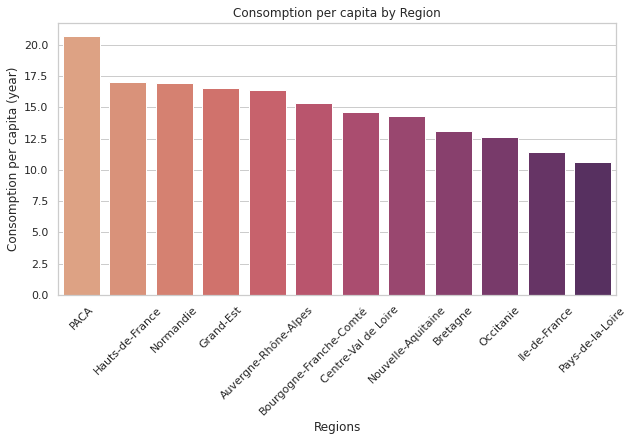

In [90]:
# Ploting Consumption per capita (Regions)

regions_consom_per_capita = regions_consom_per_capita.reset_index()

sns.set(style='whitegrid')

plt.figure(figsize=(10, 5)) 
sns.barplot(x='Regions', y='Consomption_per_capita(year)', 
            data=regions_consom_per_capita, 
            palette='flare', 
            hue='Regions', legend=False)

plt.xlabel('Regions')
plt.ylabel('Consomption per capita (year)')
plt.title('Consomption per capita by Region')

plt.xticks(rotation=45)

plt.show()


#### 1.5. Quelles régions sont les plus consommatrices par km2 ? Que pouvez-vous dire des résultats ?
___________________________________________

##### 1.5.1 Cleaning and Organisation

In [68]:
# Defining New Variable (regions_size)
regions_size = regions_consom_per_capita
regions_size = regions_size.sort_values(by='Regions', ascending=True)

In [69]:
# Adding a new column
regions_size['Superficie(km2)'] = ['69711','47784','27208','39151','57441','31806','12011','29907','84036','72724','31400','32082'] 


In [70]:
# Dropping useless columns
regions_size = regions_size.drop(columns=['Population_2022','Consomption_per_capita(year)'])

In [71]:

regions_consom_per_size = regions_size

In [72]:
regions_consom_per_size=regions_consom_per_size.astype({'Superficie(km2)':'int'})
regions_consom_per_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 4 to 11
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Regions           12 non-null     object
 1   Consomption(Gwh)  12 non-null     int64 
 2   Superficie(km2)   12 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 384.0+ bytes


In [77]:
# Dividing Consomption per Superficie
regions_consom_per_size['Consomption_per_size(Gwh/km2)']=regions_consom_per_size['Consomption(Gwh)']/regions_consom_per_size['Superficie(km2)']
regions_consom_per_size.sort_values(by='Consomption_per_size(Gwh/km2)', ascending=False)

,Regions,Consomption(Gwh),Superficie(km2),Consomption_per_size(Gwh/km2)
10,Ile-de-France,141593960,12011,11788.690367
1,Hauts-de-France,101815048,31806,3201.127083
0,PACA,80884421,31400,2575.936975
4,Auvergne-Rhône-Alpes,134068058,69711,1923.198032
2,Normandie,56079329,29907,1875.123851
11,Pays-de-la-Loire,54793090,32082,1707.907549
8,Bretagne,45053105,27208,1655.877132
3,Grand-Est,91868917,57441,1599.361380
9,Occitanie,76903481,72724,1057.470450
7,Nouvelle-Aquitaine,87595610,84036,1042.358156


In [85]:
regions_consom_per_size = regions_consom_per_size.sort_values(by='Consomption_per_size(Gwh/km2)', ascending=False)
regions_consom_per_size

,index,Regions,Consomption(Gwh),Superficie(km2),Consomption_per_size(Gwh/km2)
6,10,Ile-de-France,141593960,12011,11788.690367
5,1,Hauts-de-France,101815048,31806,3201.127083
10,0,PACA,80884421,31400,2575.936975
0,4,Auvergne-Rhône-Alpes,134068058,69711,1923.198032
7,2,Normandie,56079329,29907,1875.123851
11,11,Pays-de-la-Loire,54793090,32082,1707.907549
2,8,Bretagne,45053105,27208,1655.877132
4,3,Grand-Est,91868917,57441,1599.361380
9,9,Occitanie,76903481,72724,1057.470450
8,7,Nouvelle-Aquitaine,87595610,84036,1042.358156


##### 1.5.2 Answer:

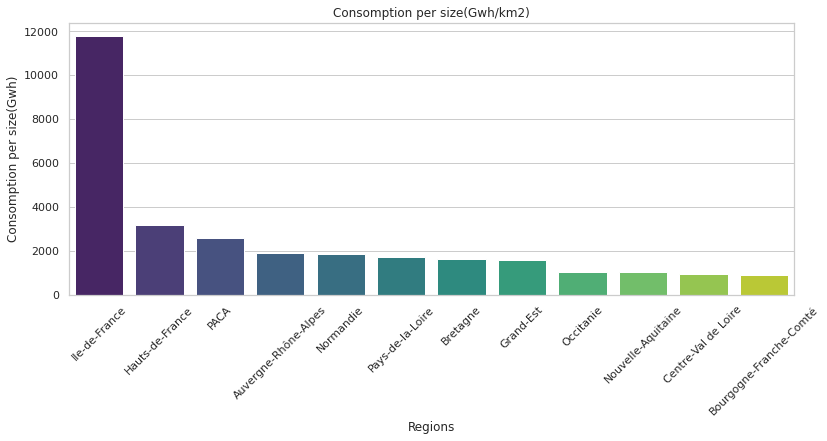

In [93]:
# Ploting Consomption per size(Gwh/km2)
sns.set(style='whitegrid')

plt.figure(figsize=(13, 5)) 
sns.barplot(x='Regions', y='Consomption_per_size(Gwh/km2)', 
            data=regions_consom_per_size, 
            palette='viridis',
            hue='Regions', legend=False)

plt.xlabel('Regions')
plt.ylabel('Consomption per size(Gwh)')
plt.title('Consomption per size(Gwh/km2)')

plt.xticks(rotation=45)

plt.show()

_______________________________________
### 2.Etude de la production non renouvelable
_______________________________________

#### 2.1 Dans quelles régions produit-t-on le plus d'électricité d'origine non renouvelable ? 

#### 2.2 Quelle est l'évolution de la production d'électricité d'origine non renouvelable ? 

#### 2.3 Afficher la production nucléaire totale par région sur l'ensemble de la période.    

#### 2.4 Dans quelles régions sont situées les centrales nucléaires ? Dans quelles régions n'y a-t-il pas de centrale nucléaire ?

_____________________________________________
### 3.Etude de la production renouvelable
_____________________________________________

#### 3.1 Quelle région produit le plus d'électricité d'origine renouvelable ?
   

#### 3.2 Quelle évolution sur les dernières années ? Faîtes un joli graphique. 
   
    

#### 3.3 Quelle région a le meilleur taux " énergie produite VS puissance installée " ? 
(Assimiler la puissance installée comme étant égale au maximum produit. Attention à bien définir vos critères, cette capacité peut augmenter dans le temps)

___________________________________________________
### 4.Autonomie électrique des régions
___________________________________________________

#### 4.1. Afficher la différence entre la consommation et la production pour chaque région.

#### 4.2. Quelles régions sont autonomes ? En excès ? En déficit ?

#### 4.3. Comparer ce résultat à la colonne 'Ech. physiques'

#### 4.4. Afficher un histogramme de l'écart entre énergie produite et consommée. Calculer la moyenne et la variance de cet écart.

#### 4.5. Observer les informations concernant la région AuRA. Retrouver la signification du signe des échanges. Pourquoi la région est-elle autant exportatrice ?

====================================== Work Done ======================================